In [1]:
!pip install mxnet

     |████████████████████████████████| 68.7MB 53kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
%pylab inline
import mxnet as mx
import pandas as pd
import sys
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
from google.colab import drive

In [4]:
drive.mount('/content/gdrive',) # force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import os
os.getcwd()

'/content'

In [6]:
# data_path = '/content/gdrive/My Drive/transaction_all2_with_merch.csv'
data_path = '/content/gdrive/My Drive/transaction_all2_with_merch.csv'

In [8]:
#data = pd.read_csv('transaction_all2_with_merch.csv', sep=',')
#data.head()

In [9]:
data = pd.read_csv(data_path, sep=',')
data.head()

,customer_id,merchant_id,rating,timestamp,merchant_name_new,behav_category,customer_id_map,mechant_id_map
0,1000000,1000004,1.0,1559779200,13thcuptealounge,dining,1,1
1,1000010,1000004,1.0,1565395200,13thcuptealounge,dining,1,2
2,1000041,1000004,1.0,1577059200,13thcuptealounge,dining,1,3
3,1000111,1000004,1.0,1550016000,13thcuptealounge,dining,1,4
4,1000135,1000004,1.0,1559520000,13thcuptealounge,dining,1,5


In [10]:
data['rating'].unique()

array([1.        , 1.12195122, 1.36585366, 1.24390244, 1.48780488,
       1.6097561 , 1.73170732, 1.85365854, 1.97560976, 2.09756098,
       2.2195122 , 2.34146342, 2.46341463, 2.95121951, 2.58536585,
       2.70731707, 3.07317073, 3.31707317, 3.56097561, 2.82926829,
       3.43902439, 4.04878049, 3.80487805, 3.19512195, 3.92682927,
       4.41463415, 4.53658537, 5.        , 4.7804878 , 4.17073171,
       3.68292683, 4.29268293, 4.90243902])

In [11]:
#data = pd.read_csv('transaction_all2_2.csv', sep=',', usecols=(2, 4, 5))

#data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/DeepFM/transaction_all2_with_merch.csv', sep=',')
#data.head()

In [12]:
#data.rename(columns={"customer_id_map": "userId", "mechant_id_map": "merchantId", "merchant_name_new": "merchantname","behav_category": "category"})

In [13]:
data = data.rename(columns={"customer_id_map": "userId", "mechant_id_map": "merchantId", "merchant_name_new": "merchantname","behav_category": "category"})
data.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId
0,1000000,1000004,1.0,1559779200,13thcuptealounge,dining,1,1
1,1000010,1000004,1.0,1565395200,13thcuptealounge,dining,1,2
2,1000041,1000004,1.0,1577059200,13thcuptealounge,dining,1,3
3,1000111,1000004,1.0,1550016000,13thcuptealounge,dining,1,4
4,1000135,1000004,1.0,1559520000,13thcuptealounge,dining,1,5


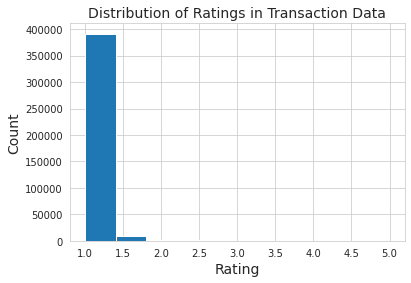

In [14]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in Transaction Data", fontsize=14)
plt.show()

### Looks Ratings 
- Ratings has only 2 value s- 1.0 and 1.5

### Continue ...

##

In [15]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("merchant id min/max: ", data['merchantId'].min(), data['merchantId'].max())
print("# unique merchants: ", numpy.unique(data['merchantId']).shape[0])

user id min/max:  1 8699
# unique users:  8699

merchant id min/max:  1 8540
# unique merchants:  8540


In [16]:
n_users, n_merchants = 8699, 8540
batch_size = 2500

In [17]:
data.shape

(403046, 8)

In [18]:
n = 303046

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

# Use the first 19M samples to train the model
train_users = data['userId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_merchants = data['merchantId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_ratings = data['rating'].values[:n]

# Use the remaining ~1M samples for validation of the model
valid_users = data['userId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_merchants = data['merchantId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_ratings = data['rating'].values[n:]

In [19]:
#valid_ratings

In [20]:
#valid_merchants,valid_ratings,valid_users

In [21]:
#valid_users

In [22]:
#train_users

In [23]:
#train_merchants

In [24]:
#train_ratings

In [25]:
#Deep matrix factorization
X_train = mx.io.NDArrayIter({'user': train_users, 'merchant': train_merchants}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'merchant': valid_merchants}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

merchant = mx.symbol.Variable("merchant")
merchant = mx.symbol.Embedding(data=merchant, input_dim=n_merchants, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, merchant)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'merchant'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Train-rmse=0.486440
INFO:root:Epoch[0] Time cost=2.157
INFO:root:Epoch[0] Validation-rmse=0.136970
INFO:root:Epoch[1] Train-rmse=0.128922
INFO:root:Epoch[1] Time cost=2.172
INFO:root:Epoch[1] Validation-rmse=0.127093
INFO:root:Epoch[2] Train-rmse=0.125153
INFO:root:Epoch[2] Time cost=2.143
INFO:root:Epoch[2] Validation-rmse=0.126738
INFO:root:Epoch[3] Train-rmse=0.124766
INFO:root:Epoch[3] Time cost=2.147
INFO:root:Epoch[3] Validation-rmse=0.126791
INFO:root:Epoch[4] Train-rmse=0.124581
INFO:root:Epoch[4] Time cost=2.149
INFO:root:Epoch[4] Validation-rmse=0.126792


In [26]:
category = data
category.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId
0,1004455,1000117,1.000000,1548374400,absolutescuba,entertainment,3149,977
1,1000734,1008131,1.121951,1554768000,venusdailymart,retail stores,5495,2706
2,1000300,1008252,1.000000,1564099200,wabisabi,dining,5673,1713
3,1000315,1000876,1.000000,1555718400,bigvaluesupermarket,retail stores,372,221
4,1003524,1002801,1.731707,1572480000,goldenresidency,travel,1273,817


In [27]:
labels_str = [label for label in category['category']]
label_set = numpy.unique(labels_str)
label_idxs = {l: i for i, l in enumerate(label_set)}
label_idxs

{'apparel and accessories': 0,
 'dining': 1,
 'entertainment': 2,
 'miscellaneous stores': 3,
 'personal service providers': 4,
 'retail stores': 5,
 'travel': 6}

In [28]:
labels = np.empty(n_merchants)
for merchantId, label in zip(category['merchantId'], labels_str):
    labels[merchantId-1] = label_idxs[label]

train_category = np.array([labels[int(j)] for j in train_merchants])
valid_category = np.array([labels[int(j)] for j in valid_merchants])
train_category[:10]

array([1., 5., 0., 6., 5., 1., 6., 5., 5., 6.])

In [29]:
X_train = mx.io.NDArrayIter({'user': train_users, 'merchant': train_merchants, 'merchant_category': train_category}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'merchant': valid_merchants, 'merchant_category': valid_category}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15)

merchant = mx.symbol.Variable("merchant")
merchant = mx.symbol.Embedding(data=merchant, input_dim=n_merchants, output_dim=20) # Reduce from 25 to 20

# We need to add in a third embedding layer for genre
merchant_category = mx.symbol.Variable("merchant_category")
merchant_category = mx.symbol.Embedding(data=merchant_category, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, merchant, merchant_category)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'merchant', 'merchant_category'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Train-rmse=0.467230
INFO:root:Epoch[0] Time cost=2.069
INFO:root:Epoch[0] Validation-rmse=0.136883
INFO:root:Epoch[1] Train-rmse=0.129061
INFO:root:Epoch[1] Time cost=2.061
INFO:root:Epoch[1] Validation-rmse=0.126928
INFO:root:Epoch[2] Train-rmse=0.124479
INFO:root:Epoch[2] Time cost=2.075
INFO:root:Epoch[2] Validation-rmse=0.126114
INFO:root:Epoch[3] Train-rmse=0.123780
INFO:root:Epoch[3] Time cost=2.067
INFO:root:Epoch[3] Validation-rmse=0.126083
INFO:root:Epoch[4] Train-rmse=0.123477
INFO:root:Epoch[4] Time cost=2.093
INFO:root:Epoch[4] Validation-rmse=0.126070


### Inferenec Experiment

In [30]:
all_category = np.array([labels[int(j)] for j in train_merchants] + [labels[int(j)] for j in valid_merchants])


In [31]:
all_category.shape

(403046,)

In [32]:
all_users = data['userId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
all_merchants = data['merchantId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
all_ratings = data['rating'].values[:]


In [33]:
all_user_merchants_pred_iter = mx.io.NDArrayIter({'user': all_users, 'merchant': all_merchants, 'merchant_category': all_category}, 
                           label=all_ratings, batch_size=batch_size)


In [34]:
all_user_merchants_pred_rating = model.predict(all_user_merchants_pred_iter)

In [35]:
list_of_pred_ratings = all_user_merchants_pred_rating.squeeze()

In [36]:
type(list_of_pred_ratings)

mxnet.ndarray.ndarray.NDArray

In [37]:
list_of_pred_ratings = list_of_pred_ratings.asnumpy()

In [38]:
type(list_of_pred_ratings)

numpy.ndarray

In [39]:
list_of_pred_ratings.shape

(403046,)

In [40]:
data.shape

(403046, 8)

In [41]:
data['currrent_prediction'] = list_of_pred_ratings

In [42]:
data.head()

,customer_id,merchant_id,rating,timestamp,merchantname,category,userId,merchantId,currrent_prediction
0,1004455,1000117,1.000000,1548374400,absolutescuba,entertainment,3149,977,0.984118
1,1000734,1008131,1.121951,1554768000,venusdailymart,retail stores,5495,2706,1.007609
2,1000300,1008252,1.000000,1564099200,wabisabi,dining,5673,1713,1.102690
3,1000315,1000876,1.000000,1555718400,bigvaluesupermarket,retail stores,372,221,1.125118
4,1003524,1002801,1.731707,1572480000,goldenresidency,travel,1273,817,1.189989


### Framing Meta info for User, merchant-category

In [43]:
all_users[0:3]

array([3148, 5494, 5672])

In [44]:
## Needed
all_unique_users = np.unique(all_users)

In [45]:
all_unique_users.shape

(8699,)

In [46]:
all_category.shape

(403046,)

In [47]:
all_merchants.shape

(403046,)

In [48]:
all_merchant_category = np.zeros(shape=(all_merchants.shape[0], 2))

In [49]:
all_merchant_category[:,0] = all_merchants
all_merchant_category[:,1] = all_category

In [50]:
all_merchant_category_df = pd.DataFrame(all_merchant_category)

In [51]:
all_merchant_category_uniq = all_merchant_category_df.drop_duplicates()

In [52]:
## 
all_merchant_category_uniq = all_merchant_category_uniq.to_numpy()

In [53]:
all_merchant_category_uniq.shape

(8540, 2)

In [54]:
all_merchant_category_uniq[:3]

array([[9.760e+02, 1.000e+00],
       [2.705e+03, 5.000e+00],
       [1.712e+03, 0.000e+00]])

### Infernce for particular user

In [55]:
label_idxs

{'apparel and accessories': 0,
 'dining': 1,
 'entertainment': 2,
 'miscellaneous stores': 3,
 'personal service providers': 4,
 'retail stores': 5,
 'travel': 6}

In [56]:
category_dict = { v:k for k,v in label_idxs.items()}

In [57]:
category_dict

{0: 'apparel and accessories',
 1: 'dining',
 2: 'entertainment',
 3: 'miscellaneous stores',
 4: 'personal service providers',
 5: 'retail stores',
 6: 'travel'}

In [58]:
userId = 438
user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
# user_feature_over_all_merchants.shape
print(train_merchants.shape)
print(all_merchant_category_uniq[:,0].shape)

(303046,)
(8540,)


In [59]:
user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
custom_inputs = mx.io.NDArrayIter({'user': user_feature_over_all_merchants, 
                                   'merchant': all_merchant_category_uniq[:,0], 
                                   'merchant_category': all_merchant_category_uniq[:,1]},
                                  batch_size=batch_size)
pred_ratings = model.predict(custom_inputs)

In [60]:
pred_ratings.shape

(8540, 1)

In [61]:
pred_ratings[:3]


[[1.0000185]
 [1.0103716]
 [1.0417438]]
<NDArray 3x1 @cpu(0)>

In [62]:
pred_ratings.squeeze().sort()


[0.64898354 0.8360821  0.85701203 ... 1.1528662  1.1731972  1.201996  ]
<NDArray 8540 @cpu(0)>

In [63]:
pred_ratings.squeeze().argsort()


[8508. 5767. 5704. ... 7933. 4259. 7695.]
<NDArray 8540 @cpu(0)>

In [64]:
# https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order

In [65]:
topk = pred_ratings.squeeze().argsort()[::-1][:20]

In [66]:
topk = topk.asnumpy()

In [67]:
topk

array([7695., 4259., 7933., 7407., 7829., 8023., 6488., 4628., 8063.,
       4873.,  803., 1183., 4842.,  108., 3654., 6319., 3538., 2307.,
       6458., 4520.], dtype=float32)

In [68]:
type(all_merchant_category_uniq)

numpy.ndarray

In [69]:
all_merchant_category_uniq[0,:]

array([976.,   1.])

In [70]:
topk = [int(k) for k in topk]

In [71]:
inv_label_idxs = { v:k for k,v in label_idxs.items()}

In [72]:
inv_label_idxs

{0: 'apparel and accessories',
 1: 'dining',
 2: 'entertainment',
 3: 'miscellaneous stores',
 4: 'personal service providers',
 5: 'retail stores',
 6: 'travel'}

In [73]:
all_merchant_category_uniq[0,:]

array([976.,   1.])

In [74]:
print(f"merchantid - categoryid - category ")
for k in topk:
  merchantid, categoryid = all_merchant_category_uniq[k, :]
  merchantid = int(merchantid)
  categoryid = int(categoryid)
  category = inv_label_idxs[categoryid]
  print(f"{merchantid} - {categoryid} - {category} ")


merchantid - categoryid - category 
7111 - 0 - apparel and accessories 
7207 - 3 - miscellaneous stores 
7018 - 1 - dining 
3226 - 6 - travel 
5254 - 6 - travel 
5788 - 1 - dining 
3593 - 1 - dining 
2805 - 6 - travel 
7399 - 1 - dining 
7022 - 1 - dining 
4033 - 1 - dining 
7342 - 1 - dining 
6379 - 5 - retail stores 
1137 - 5 - retail stores 
2092 - 5 - retail stores 
5650 - 1 - dining 
4377 - 5 - retail stores 
6928 - 5 - retail stores 
5872 - 1 - dining 
6997 - 1 - dining 


In [75]:
def find_rating_for_user(userId, topk=20):

  merchants = list() 

  if userId in all_unique_users:
    # valid user
    user_feature_over_all_merchants = np.repeat(userId, all_merchant_category_uniq.shape[0])
    custom_inputs = mx.io.NDArrayIter({'user': user_feature_over_all_merchants, 
                                       'merchant': all_merchant_category_uniq[:,0], 
                                       'merchant_category': all_merchant_category_uniq[:,1]},
                                      batch_size=batch_size)
    pred_ratings = model.predict(custom_inputs)
    topk_inds = pred_ratings.squeeze().argsort()[::-1][:topk]
    topk_scores = pred_ratings.squeeze().sort()[::-1][:topk]
    topk_scores = topk_scores.asnumpy()
    topk_inds = topk_inds.asnumpy()
    topk_inds = [int(k) for k in topk_inds]


    # print(topk_scores)

    for idx, k in enumerate(topk_inds):
        merchantid, categoryid = all_merchant_category_uniq[k, :]
        merchantid = int(merchantid)
        categoryid = int(categoryid)
        category = inv_label_idxs[categoryid]
        score = topk_scores[idx]
        # print(f"{merchantid} - {categoryid} - {category} ")

        merchants.append(tuple([merchantid, categoryid, category, score]))
  else:
    # Invalid user
    print('Invalid User')
    pass
  return merchants

In [76]:
find_rating_for_user(438, topk=15)

[(7111, 0, 'apparel and accessories', 1.201996),
 (7207, 3, 'miscellaneous stores', 1.1731972),
 (7018, 1, 'dining', 1.1528662),
 (3226, 6, 'travel', 1.151754),
 (5254, 6, 'travel', 1.1512554),
 (5788, 1, 'dining', 1.148249),
 (3593, 1, 'dining', 1.1466895),
 (2805, 6, 'travel', 1.1439562),
 (7399, 1, 'dining', 1.1428219),
 (7022, 1, 'dining', 1.1422136),
 (4033, 1, 'dining', 1.1421463),
 (7342, 1, 'dining', 1.1408467),
 (6379, 5, 'retail stores', 1.1386882),
 (1137, 5, 'retail stores', 1.1363976),
 (2092, 5, 'retail stores', 1.1327119)]

### Inference for particular Merchant

In [77]:
query_merchant_id = 4881

In [78]:
query_merchant_id in all_merchant_category_uniq[:,0]

True

In [79]:
np.where(all_merchant_category_uniq[:,0] ==  query_merchant_id)

(array([6267]),)

In [80]:
current_merchant_index = np.where(all_merchant_category_uniq[:,0] ==  query_merchant_id)

In [81]:
all_merchant_category_uniq[current_merchant_index, 0]

array([[4881.]])

In [82]:
current_merchant_categories = all_merchant_category_uniq[current_merchant_index, 1]

In [84]:
# current_merchant_categories[0, 0 ]
#for k in current_merchant_categories:

In [85]:
if current_merchant_categories.shape[0] == 1:
  current_merchant_categories_rep = np.repeat(current_merchant_categories[0, 0], all_unique_users.shape[0])

In [86]:
custom_inputs = mx.io.NDArrayIter({'user': all_unique_users,
                                   'merchant': all_merchant_category_uniq[current_merchant_index,0], 
                                   'merchant_category': all_merchant_category_uniq[current_merchant_index,1]},
                                  batch_size=batch_size)

In [87]:
pred_ratings = model.predict(custom_inputs)

IndexError: ignored

In [88]:
all_unique_users.shape[0]

8699

In [89]:
merchantId = 4881
merchantId in all_merchant_category_uniq[:,0]
current_merchant_index = np.where(all_merchant_category_uniq[:,0] == merchantId)
current_merchant_categories = all_merchant_category_uniq[current_merchant_index, 1]
print(current_merchant_categories)
print(current_merchant_categories.shape)

[[5.]]
(1, 1)


In [90]:
current_merchant_categories.shape

(1, 1)

In [91]:
all_input_categories = np.zeros(current_merchant_categories.shape[0] * all_unique_users.shape[0])
all_input_merchants = np.repeat(merchantId, current_merchant_categories.shape[0] * all_unique_users.shape[0])


In [92]:
for idx, various_category in enumerate(current_merchant_categories[:]):
      start = idx * all_unique_users.shape[0]
      end = (idx + 1) * all_unique_users.shape[0]
      all_input_categories[start:end] = various_category

In [93]:
all_input_categories.shape

(8699,)

In [94]:
all_unique_users.shape[0] * 3

26097

In [95]:
all_unique_users[6:10]

array([6, 7, 8, 9])

In [96]:
merchantId

4881

In [97]:
#np.where?
#np.where( #(all_merchant_category_uniq[:, 0], 4881))

In [110]:
find_rating_for_a_merchant(merchantId=4881, topk=10)

[(1215, 5, 'retail stores', 1.978301),
 (3226, 5, 'retail stores', 1.9250828),
 (631, 5, 'retail stores', 1.9110672),
 (1214, 5, 'retail stores', 1.9055759),
 (632, 5, 'retail stores', 1.8987972),
 (1213, 5, 'retail stores', 1.8975078),
 (1218, 5, 'retail stores', 1.8842108),
 (635, 5, 'retail stores', 1.8430115),
 (3232, 5, 'retail stores', 1.8418028),
 (3225, 5, 'retail stores', 1.8414954)]

In [99]:
merchantId = 4881
current_merchant_index = np.where(all_merchant_category_uniq[:,0] == merchantId)

current_merchant_categories = all_merchant_category_uniq[current_merchant_index, 1]

In [100]:
all_input_categories = np.zeros(current_merchant_categories.shape[0] * all_unique_users.shape[0])

In [101]:
all_input_merchants = np.repeat(merchantId, current_merchant_categories.shape[0] * all_unique_users.shape[0])
for idx, various_category in enumerate(current_merchant_categories[:]):
  start = idx * all_unique_users.shape[0]
  end = (idx + 1) * all_unique_users.shape[0]
  all_input_categories[start:end] = various_category

In [102]:

all_input_users =  np.hstack([all_unique_users] * 3)


custom_inputs = mx.io.NDArrayIter({'user': all_input_users, 
                                    'merchant': all_input_merchants, 
                                    'merchant_category': all_input_categories},
                                  batch_size=batch_size)
pred_ratings = model.predict(custom_inputs)

In [103]:

topk_inds = pred_ratings.squeeze().argsort()[::-1][:10].asnumpy()  # pred_ratings.squeeze().argsort()[::-1][:topk]
topk_scores = pred_ratings.squeeze().sort()[::-1][:10].asnumpy()
# topk_scores = topk_scores
topk_inds = [int(k) for k in topk_inds]

In [104]:
users = []

for idx, k in enumerate(topk_inds):
    userid  = all_input_users[k] 
    categoryid = all_input_categories[k]

    userid = int(userid)
    categoryid = int(categoryid)

    category = inv_label_idxs[categoryid]
    score = topk_scores[idx]        

    users.append(tuple([userid, categoryid, category, score]))



In [105]:
users

[(1215, 5, 'retail stores', 1.978301),
 (3226, 5, 'retail stores', 1.9250828),
 (631, 5, 'retail stores', 1.9110672),
 (1214, 5, 'retail stores', 1.9055759),
 (632, 5, 'retail stores', 1.8987972),
 (1213, 5, 'retail stores', 1.8975078),
 (1218, 5, 'retail stores', 1.8842108),
 (635, 5, 'retail stores', 1.8430115),
 (3232, 5, 'retail stores', 1.8418028),
 (3225, 5, 'retail stores', 1.8414954)]

### DOne!

In [108]:
print(find_rating_for_a_merchant(4881, 5))
# User id, Cateegory id, category Name, rating 

[(1215, 5, 'retail stores', 1.978301), (3226, 5, 'retail stores', 1.9250828), (631, 5, 'retail stores', 1.9110672), (1214, 5, 'retail stores', 1.9055759), (632, 5, 'retail stores', 1.8987972)]


In [107]:
def find_rating_for_a_merchant(merchantId, topk=10):
  users = list()
  if merchantId in all_merchant_category_uniq[:,0]:

    current_merchant_index = np.where(all_merchant_category_uniq[:,0] == merchantId)

    current_merchant_categories = all_merchant_category_uniq[current_merchant_index, 1]
    

    all_input_categories = np.zeros(current_merchant_categories.shape[0] * all_unique_users.shape[0])
    all_input_merchants = np.repeat(merchantId, current_merchant_categories.shape[0] * all_unique_users.shape[0])
    for idx, various_category in enumerate(current_merchant_categories[:]):
      start = idx * all_unique_users.shape[0]
      end = (idx + 1) * all_unique_users.shape[0]
      all_input_categories[start:end] = various_category


    
    all_input_users =  np.hstack([all_unique_users] * 3)
    
    
    custom_inputs = mx.io.NDArrayIter({'user': all_input_users, 
                                       'merchant': all_input_merchants, 
                                       'merchant_category': all_input_categories},
                                      batch_size=batch_size)
    pred_ratings = model.predict(custom_inputs)
    
    topk_inds = pred_ratings.squeeze().argsort()[::-1][:topk].asnumpy()
    topk_scores = pred_ratings.squeeze().sort()[::-1][:topk].asnumpy()
    # topk_scores = topk_scores.asnumpy()
    topk_inds = [int(k) for k in topk_inds]

    for idx, k in enumerate(topk_inds):
        userid  = all_input_users[k] 
        categoryid = all_input_categories[k]

        userid = int(userid)
        categoryid = int(categoryid)

        category = inv_label_idxs[categoryid]
        score = topk_scores[idx]        

        users.append(tuple([userid, categoryid, category, score]))
  else:
    # Invalid user
    print('Invalid User')
    pass
  return users


In [109]:
print(find_rating_for_a_merchant(4881, 5))
# User id, Cateegory id, category Name, rating 

[(1215, 5, 'retail stores', 1.978301), (3226, 5, 'retail stores', 1.9250828), (631, 5, 'retail stores', 1.9110672), (1214, 5, 'retail stores', 1.9055759), (632, 5, 'retail stores', 1.8987972)]
